In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv('train.csv')

In [85]:
df.dropna(inplace=True)

In [86]:
df.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    384004 non-null  int64  
 1   Age                   384004 non-null  float64
 2   Gender                384004 non-null  object 
 3   Annual Income         384004 non-null  float64
 4   Marital Status        384004 non-null  object 
 5   Number of Dependents  384004 non-null  float64
 6   Education Level       384004 non-null  object 
 7   Occupation            384004 non-null  object 
 8   Health Score          384004 non-null  float64
 9   Location              384004 non-null  object 
 10  Policy Type           384004 non-null  object 
 11  Previous Claims       384004 non-null  float64
 12  Vehicle Age           384004 non-null  float64
 13  Credit Score          384004 non-null  float64
 14  Insurance Duration    384004 non-null  float64
 15  Poli

In [88]:
numerical_features = df.select_dtypes(include=['int64', 'float64'])

In [89]:
features = list(numerical_features.columns)

In [97]:
X = df.drop(['Premium Amount', 'id'], axis = 1)
y = df[['Premium Amount']]

In [96]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
objs = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
df[objs] = df[objs].apply(label_encoder.fit_transform)


In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Lasso

In [21]:
def calRMSLE(y_test, y_pred):
    from sklearn.metrics import mean_squared_error

    y_test = np.log1p(y_test)
    y_pred = np.clip(y_pred, 0, None)
    y_pred = np.log1p(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmsle = np.sqrt(mse)

    return rmsle




In [22]:
alphas = np.linspace(0.001, 1000, 10000)

Best alpha: 1.7017115315315317


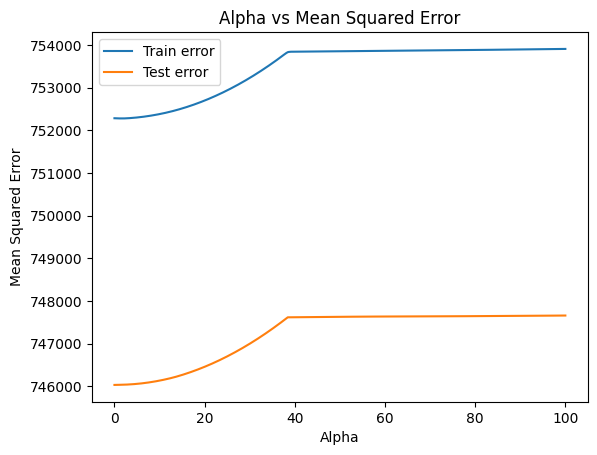

In [85]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits = 10000)
alphas = np.linspace(0.00001, 100, 1000)

mean_errors = []
test_erros = []

for a in alphas:
    fold_errors = [] 
    model = Lasso(alpha=a)
    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_error = mean_squared_error(y_test, y_pred)
        fold_errors.append(fold_error)
    
    
    mean_errors.append(np.mean(fold_errors))
    test_y_pred = model.predict(X_test)
    test_erros.append(mean_squared_error(y_test, test_y_pred))


best_alpha = alphas[np.argmin(mean_errors)]
print(f"Best alpha: {best_alpha}")

plt.plot(alphas, mean_errors, label="Train error")
plt.plot(alphas, test_erros, label="Test error")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Alpha vs Mean Squared Error")
plt.legend()
plt.show()


In [107]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

alphas = np.linspace(0.001, 100, 1000)
lasso = LassoCV(cv = 10, alphas=alphas, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmsle = calRMSLE(y_test, y_pred)
print("mse", mse)
print("rmsle", rmsle)




/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1659: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mse 751090.0980747818
rmsle 1.1645489767646955


In [111]:
vals = lasso.coef_
features = X.columns
non_zero_indices = vals != 0
non_zero_features = np.array(features)[non_zero_indices]

# Print the non-zero features
print(len(non_zero_features))
print(len(features))


13
19


In [ ]:
from cuml.model_selec import Lasso

In [5]:
from cuml.linear_model import Lasso
from sklearn.model_selection import KFold


alphas = np.linspace(0.001, 100, 1000)
cvs = [10, 20, 40, 100]
best_alpha = float('infinity')
min_m = float('infinity')
best_cv = 101
rmsle = 0

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scores = []
for a in alphas:
    lasso = Lasso(alpha=a)
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
          # Set alpha; this can be tuned with Optuna
        lasso.fit(X_train, y_train)

        y_pred = lasso.predict(X_val)
        
        mse = mean_squared_error(y_val.to_array(), y_pred.to_array())  # Convert to numpy arrays
        mse_scores.append(mse)
    
    mean_mse = np.mean(mse_scores)
    if best_mse > mean_mse:
        best_mse = mean_mse
        best_alpha = 0
    



    


ImportError: cannot import name 'LassoCV' from 'cuml.linear_model' (/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/cuml/linear_model/__init__.py)

In [25]:
y.shape

(384004, 1)

In [94]:
min_m

751102.1163774149

In [95]:
rmsle

1.1646400027652477

In [88]:
best_cv

40

In [88]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1000)
lasso.fit(X_train, y_train)

Lasso(alpha=1000)

In [1]:
from cuml.linear_model import Lasso

In [93]:
lasso.score(X_train, y_train)

0.003193625841451442

In [94]:
lasso.alpha_

1.3256278278278277

In [95]:
from sklearn.metrics import mean_squared_error

y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

746032.3589300507

In [55]:
lasso.alpha_

1.0

In [96]:
lasso.coef_

array([ 3.44259131e-06, -2.99972279e-01, -5.61299719e-04, -0.00000000e+00,
        1.04847853e+00,  3.88637617e+01,  3.57923204e-01, -1.70283945e-01,
       -0.00000000e+00])

## Ridge

In [98]:
from sklearn.linear_model import RidgeCV
alphas = np.linspace(0.001, 100, 1000)
ridge = RidgeCV(cv = 10, alphas=alphas)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 1.01099099e-01, 2.01198198e-01, 3.01297297e-01,
       4.01396396e-01, 5.01495495e-01, 6.01594595e-01, 7.01693694e-01,
       8.01792793e-01, 9.01891892e-01, 1.00199099e+00, 1.10209009e+00,
       1.20218919e+00, 1.30228829e+00, 1.40238739e+00, 1.50248649e+00,
       1.60258559e+00, 1.70268468e+00, 1.80278378e+00, 1.90288288e+00,
       2.00298198e+00, 2.10308108e+0...
       9.76977207e+01, 9.77978198e+01, 9.78979189e+01, 9.79980180e+01,
       9.80981171e+01, 9.81982162e+01, 9.82983153e+01, 9.83984144e+01,
       9.84985135e+01, 9.85986126e+01, 9.86987117e+01, 9.87988108e+01,
       9.88989099e+01, 9.89990090e+01, 9.90991081e+01, 9.91992072e+01,
       9.92993063e+01, 9.93994054e+01, 9.94995045e+01, 9.95996036e+01,
       9.96997027e+01, 9.97998018e+01, 9.98999009e+01, 1.00000000e+02]),
        cv=10)

In [99]:
ridge.alpha_

100.0

In [100]:
from sklearn.metrics import mean_squared_error

y_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

746029.0788243649

Best alpha: 550.5505599999999


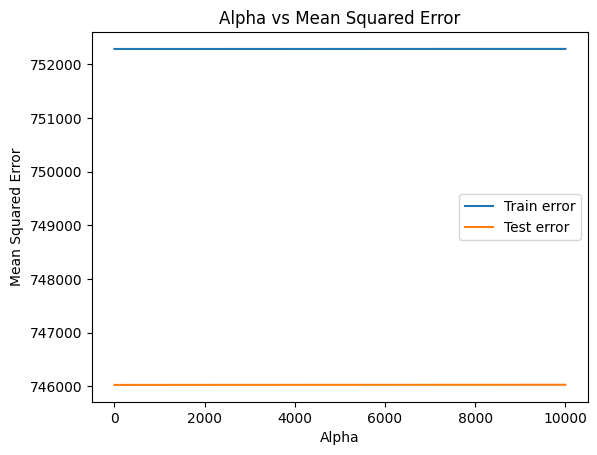

In [101]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits = 10)
alphas = np.linspace(0.00001, 10000, 1000)

mean_errors = []
test_erros = []

for a in alphas:
    fold_errors = [] 
    model = Ridge(alpha=a)
    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_error = mean_squared_error(y_test, y_pred)
        fold_errors.append(fold_error)
    
    
    mean_errors.append(np.mean(fold_errors))
    test_y_pred = model.predict(X_test)
    test_erros.append(mean_squared_error(y_test, test_y_pred))


best_alpha = alphas[np.argmin(mean_errors)]
print(f"Best alpha: {best_alpha}")

plt.plot(alphas, mean_errors, label="Train error")
plt.plot(alphas, test_erros, label="Test error")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Alpha vs Mean Squared Error")
plt.legend()
plt.show()


In [108]:
from sklearn.linear_model import Ridge
alphas = np.linspace(0.001, 100, 1000)
ridge = Ridge(alpha=550)
ridge.fit(X_train, y_train)

Ridge(alpha=550)

In [109]:
from sklearn.metrics import mean_squared_error

y_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

746029.1581989508

## Random Forest

In [113]:
X1_train = X_train[non_zero_features]
X1_test = X_test[non_zero_features]


In [114]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10, n_estimators=400, max_features=0.5)
rf.fit(X1_train, y_train)

y_pred = rf.predict(X1_test)
mse = mean_squared_error(y_test, y_pred)
rsm = calRMSLE(y_test, y_pred)

print('mse', mse)
print('rsm', rsm)

/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mse 712562.1304272786
rsm 1.1401114005378714


In [106]:
importances = rf.feature_importances_
importances.sort()
print(importances)

[0.00309031 0.0033083  0.00550558 0.00556141 0.0056192  0.00579443
 0.00581897 0.00586845 0.00760436 0.0085575  0.00987535 0.01454779
 0.02174211 0.02943793 0.08343156 0.10433301 0.11333893 0.18009488
 0.38646993]


In [34]:
features = [0.2, 0.5, 0.7, 1]
for feature in features:
    rf = RandomForestRegressor(max_depth=20, n_estimators=150, max_features=feature)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rsm = calRMSLE(y_test, y_pred)

    print('mse', mse)
    print('rsm', rsm)


/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mse 732184.97717253
rsm 1.157681469470873


/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mse 727126.0565458222
rsm 1.1503898326808366


/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mse 728599.985696829
rsm 1.151054649712353


/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mse 732030.881600273
rsm 1.1574862749227608


## Adaboost

In [116]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

base_estimator = DecisionTreeRegressor(max_depth=3)

# Initialize AdaBoostRegressor with the base estimator
ada_boost = AdaBoostRegressor(estimator=base_estimator, n_estimators=250, learning_rate=0.6, random_state=42)

# Fit the model
ada_boost.fit(X1_train, y_train)

# Predict on the test set
y_pred = ada_boost.predict(X1_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rse = calRMSLE(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"RSE: {rse}")


/home/khairnar.as/.conda/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 853923.5780458774
RSE: 1.2828954337205851


In [48]:
y_pred.min()

np.float64(1290.0086489710707)

In [60]:
test_df = pd.read_csv('test.csv')

In [67]:
test_df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [69]:
feat = features[:len(features)-1]
feat

['id',
 'Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']

In [70]:
X_df_test = test_df[feat]

In [74]:
X_df_test.shape

(800000, 9)

In [73]:
X_df_test.isnull().sum()

id                           0
Age                      12489
Annual Income            29860
Number of Dependents     73130
Health Score             49449
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
dtype: int64

In [77]:
proc_df = X_df_test.apply(lambda col: col.fillna(col.mean()) if col.dtype != 'object' else col, axis=0)

In [78]:
proc_df.shape

(800000, 9)

In [79]:
y_pred = ada_boost.predict(y_pred)
y_pred

array([1546.66927875, 1405.69724409, 1269.11356222, ..., 1269.11356222,
       1331.54308329, 1269.11356222])

In [80]:
final_df = pd.DataFrame({
    'id' : proc_df['id'],
    'Premium Amount': y_pred
})

In [81]:
final_df.head()

,id,Premium Amount
0,1200000,1546.669279
1,1200001,1405.697244
2,1200002,1269.113562
3,1200003,1269.113562
4,1200004,1269.113562


In [82]:
final_df.to_csv('submission.csv', index=False)